Idea for prediction project taken from https://towardsdatascience.com/5-data-science-projects-in-healthcare-that-will-get-you-hired-81003cadf2f3

In [121]:
%matplotlib inline
# basic python
import os
import datetime
import itertools
# data handling
import numpy as np
import pandas as pd
# visualization
import matplotlib.pyplot as plt
import seaborn as sns
# machine learning scikit learn
from sklearn import preprocessing, datasets, decomposition, tree, metrics
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, auc
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score, cross_validate
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
# imblearn
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import RandomOverSampler, SMOTE

# Stroke Data Set

dataset source: https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset

In [2]:
os.chdir("C:/users/akrue/healthdata")

In [3]:
df = pd.read_csv("C:/users/akrue/healthdata/healthcare-dataset-stroke-data.xls")

## Explorative Data Analysis

My comments are grouped and marked as follows:

<font color='blue'>-> Conclusions from the analysis beginn with a "->" and are marked blue. </font>

<font color='red'>[TODO]: todos start with [TODO]: and are marked red</font>

### Exploring the whole dataset: shape, missing values, dtypes

Getting used to the data set: Are there implausible values, outliers, etc.

<font color='red'>[TODO]: add text description of columns</font>

In [4]:
df.shape

(5110, 12)

<font color='blue'>-> potentially 5110 data points for predicting heart disease</font>

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 5110 non-null   int64  
 1   gender             5110 non-null   object 
 2   age                5110 non-null   float64
 3   hypertension       5110 non-null   int64  
 4   heart_disease      5110 non-null   int64  
 5   ever_married       5110 non-null   object 
 6   work_type          5110 non-null   object 
 7   Residence_type     5110 non-null   object 
 8   avg_glucose_level  5110 non-null   float64
 9   bmi                4909 non-null   float64
 10  smoking_status     5110 non-null   object 
 11  stroke             5110 non-null   int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 479.2+ KB


<font color='blue'>-> there are *missing values* i, the bmi column -> needs to be removed or imputed later</font>

In [6]:
df.describe()

id          age  hypertension  heart_disease  \
count   5110.000000  5110.000000   5110.000000    5110.000000   
mean   36517.829354    43.226614      0.097456       0.054012   
std    21161.721625    22.612647      0.296607       0.226063   
min       67.000000     0.080000      0.000000       0.000000   
25%    17741.250000    25.000000      0.000000       0.000000   
50%    36932.000000    45.000000      0.000000       0.000000   
75%    54682.000000    61.000000      0.000000       0.000000   
max    72940.000000    82.000000      1.000000       1.000000   

       avg_glucose_level          bmi       stroke  
count        5110.000000  4909.000000  5110.000000  
mean          106.147677    28.893237     0.048728  
std            45.283560     7.854067     0.215320  
min            55.120000    10.300000     0.000000  
25%            77.245000    23.500000     0.000000  
50%            91.885000    28.100000     0.000000  
75%           114.090000    33.100000     0.000000  
max           271.740000    97.600000     1.000000

<font color='blue'>-> avg_glucose_level, bmi looks to have *outliers* -> my decision: the outlier are not out of the possible range, thus "the data is the data" and I keep the rather extreme values in the analysis </font>

In [7]:
df.describe(include='object')

gender ever_married work_type Residence_type smoking_status
count     5110         5110      5110           5110           5110
unique       3            2         5              2              4
top     Female          Yes   Private          Urban   never smoked
freq      2994         3353      2925           2596           1892

<font color='blue'> -> some of the categorial variables can be interpreted as ordinal, e.g. smoking status and may be ever_married -> my decision: For the MVP-analysis, I treat all of them as nominal. Thus, I use a *one hot encoding* later </font>

In [8]:
# Honestly, I am not certain, whether I have an advantage from changing dtype object to category. 
#I should look that up later
for col in df:
    if df[col].dtype == np.dtype('object'):
        df[col] = df[col].astype("category")
df.dtypes 

id                      int64
gender               category
age                   float64
hypertension            int64
heart_disease           int64
ever_married         category
work_type            category
Residence_type       category
avg_glucose_level     float64
bmi                   float64
smoking_status       category
stroke                  int64
dtype: object

Learning: 5110 rows

In [9]:
len(df['id'])-len(df['id'].drop_duplicates())

0

<font color='blue'>-> because each data point has a unique id, there are no multiple data points belonging together somehow as for example when collecting multiple mearurements from the same subjects. This implies that id can be dropped without a loss</font>

In [10]:
df[df.isna().any(axis=1)].shape 

(201, 12)

In [11]:
df[df['bmi'].isnull()].shape

(201, 12)

<font color='blue'>-> missing values are indeed only present in the bmi column (this was already visible from the df.describe())</font>

### Univartiat look at the data
Here I look mainly at the distribution of each variable because we already adressed outliers and missing values

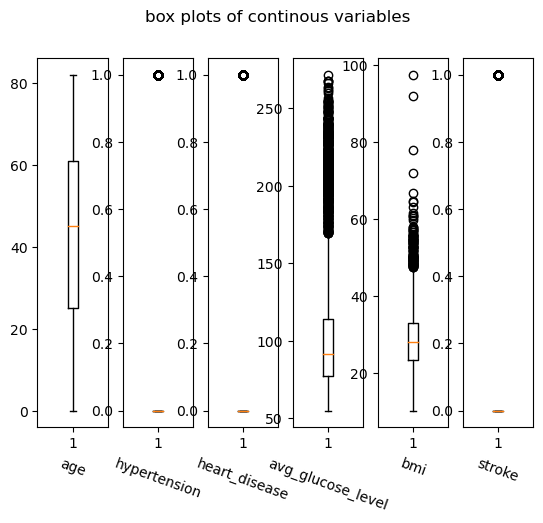

In [12]:
fig, axs = plt.subplots(1,6)
fig.suptitle('box plots of continous variables')
for i, col in enumerate(['age', 'hypertension', 'heart_disease', 'avg_glucose_level', 'bmi', 'stroke']):
    axs[i].boxplot(df[col].dropna())
    axs[i].set_xlabel(col,rotation=-20)
plt.show()

<font color='blue'>-> hypertension, heart_disease and stroke are categorial variables</font>

<font color='blue'>-> age seems to be covering the whole population</font>

<font color='blue'>->avg_glucose_level and bmi is heavily skewed and might be better described in terms of a gamma distribution or log-normal than a normal distribution</font>

<font color='blue'>->becasue units differ between the numeric variables</font>

<Axes: xlabel='bmi', ylabel='Density'>

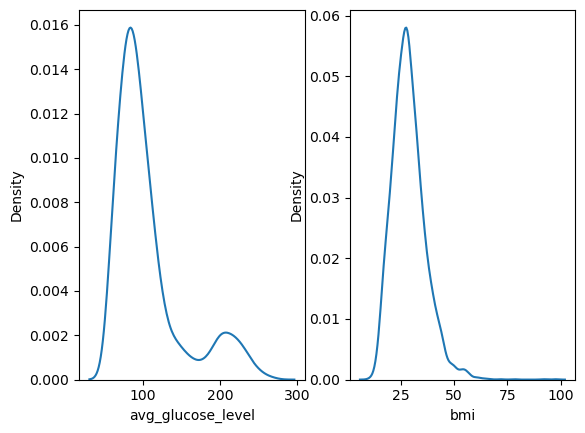

In [13]:
fig, axs = plt.subplots(1,2)
sns.kdeplot(data=df, x="avg_glucose_level", ax=axs[0])
sns.kdeplot(data=df.dropna(), x="bmi", ax=axs[1])

<font color='blue'>-> bmi is *unimodal* whereas avg_glucose_level is *bimodal*</font>

In [14]:
for col in ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']:
    print(df[col].value_counts())

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64
0    4612
1     498
Name: hypertension, dtype: int64
0    4834
1     276
Name: heart_disease, dtype: int64
Yes    3353
No     1757
Name: ever_married, dtype: int64
Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64
Urban    2596
Rural    2514
Name: Residence_type, dtype: int64
never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64
0    4861
1     249
Name: stroke, dtype: int64


<font color='blue'>-> only 1 person is neither male nor female -> only one data point in a category is a good reason to remove the data point. Because my working hypothesis is that gender does not explain much variance for the prediciton, I still keep it. </fort>

<font color='blue'>-> the data set is claerly imbalanced for heart_disease and stroke</fort>

<font color='red'>[TODO]: 'unknown' smokeing_status is actually a missing value and should not be encoded as a feature</fort>

In [15]:
df = df[df['gender'] != 'other']

In [16]:
p =df["heart_disease"].value_counts()[1]/df.shape[0]*100
f'Only {p:.0f}% of the data points contain heart disease cases'

'Only 5% of the data points contain heart disease cases'

In [17]:
dfnan = df[df.isna().any(axis=1)]

In [18]:
dfnan.iloc[15:20]

id  gender   age  hypertension  heart_disease ever_married  \
81   26015  Female  66.0             0              0          Yes   
84   70042    Male  58.0             0              0          Yes   
105   2346    Male  58.0             0              0          Yes   
112  36706  Female  76.0             0              0          Yes   
124  14164  Female  72.0             0              0          Yes   

         work_type Residence_type  avg_glucose_level  bmi   smoking_status  \
81   Self-employed          Urban             101.45  NaN          Unknown   
84         Private          Urban              71.20  NaN          Unknown   
105        Private          Urban              82.30  NaN           smokes   
112  Self-employed          Urban             106.41  NaN  formerly smoked   
124        Private          Urban             219.91  NaN          Unknown   

     stroke  
81        1  
84        1  
105       1  
112       1  
124       1

<font color='blue'>-> these data would be lost if .dropna would be executed. My decision: I replace the values with the median because so that I can keep the data for learning. Median is preferable to the mean as the outliers would draw the mean towards the extreme obersvations.</font>

### Bi-variat look at the data

In [19]:
"""for comb in itertools.combinations(list(df.columns), 2):
    print(comb)
    if df[comb[1]].nunique() <= 5:
        sns.kdeplot(x=comb[0], hue=comb[1], data=df)
        sns.histplot(x=comb[0], hue=comb[1], data=df)
    elif df[comb[0]].nunique() <= 5:
         sns.kdeplot(x=comb[1], hue=comb[0], data=df)
    else:
        sns.scatterplot(x=comb[0], y=comb[1], data=df)
    plt.show()
 """   

'for comb in itertools.combinations(list(df.columns), 2):\n    print(comb)\n    if df[comb[1]].nunique() <= 5:\n        sns.kdeplot(x=comb[0], hue=comb[1], data=df)\n        sns.histplot(x=comb[0], hue=comb[1], data=df)\n    elif df[comb[0]].nunique() <= 5:\n         sns.kdeplot(x=comb[1], hue=comb[0], data=df)\n    else:\n        sns.scatterplot(x=comb[0], y=comb[1], data=df)\n    plt.show()\n '

<font color='red'>[TODO]: this is my failed attempt at visualizing all variable combinations. Because of the limited time, I abandoned the idea and programmed individual plots instead.</font>

In [20]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

<Axes: xlabel='age', ylabel='Count'>

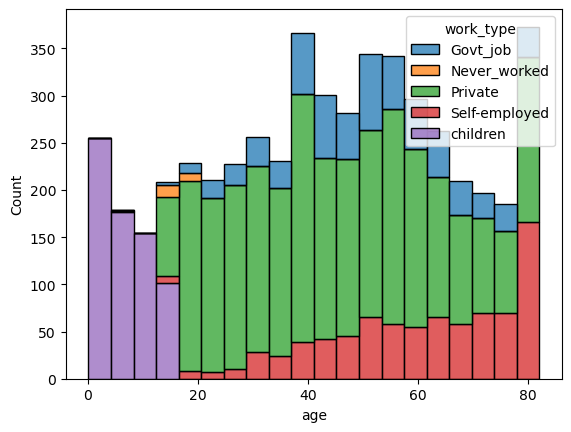

In [21]:
sns.histplot(x='age', hue='work_type', data=df,multiple="stack") # stacking for better visibility

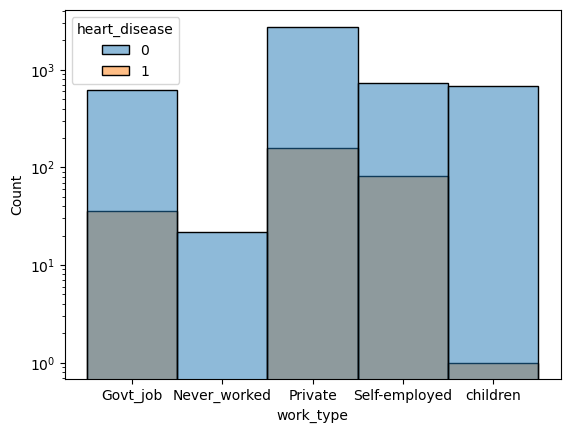

In [22]:
sns.histplot(x='work_type', hue='heart_disease', data=df)
plt.yscale('log') # log scale for better visibility

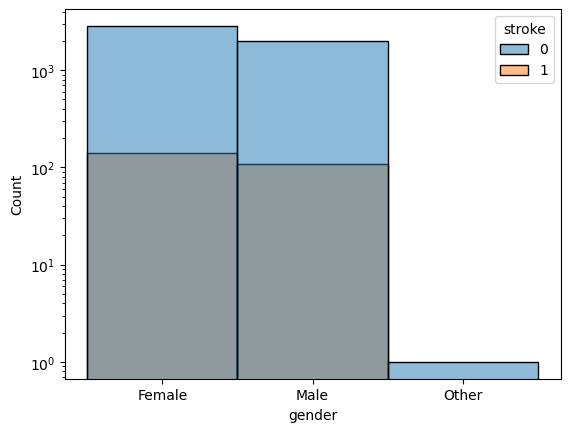

In [23]:
sns.histplot(df, x="gender", hue="stroke")
plt.yscale('log') # log scale for better visibility

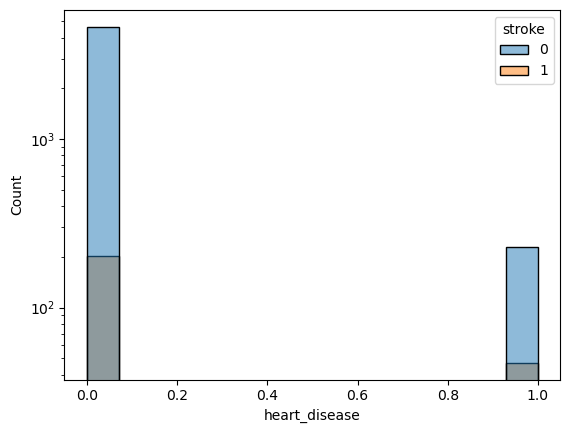

In [24]:
sns.histplot(df, x="heart_disease", hue="stroke")
plt.yscale('log') # log scale for better visibility

In [25]:
n_heartdis_stroke = df.loc[(df['heart_disease'] ==1) & (df['stroke'] ==1)].shape[0]

In [26]:
n_heartdis_nostroke =df.loc[(df['heart_disease'] ==1) & (df['stroke'] ==0)].shape[0]

In [27]:
n_noheartdis_stroke =df.loc[(df['heart_disease'] ==0) & (df['stroke'] ==1)].shape[0]

In [28]:
n_noheartdis_nostroke =df.loc[(df['heart_disease'] ==0) & (df['stroke'] ==0)].shape[0]

In [29]:
f'Relative frequency of stroke if heart_disease=1 {n_heartdis_stroke/(n_heartdis_stroke+n_heartdis_nostroke):.2f} and if heart_disease=0 {n_noheartdis_stroke/(n_noheartdis_stroke+n_noheartdis_nostroke):.2f}'

'Relative frequency of stroke if heart_disease=1 0.17 and if heart_disease=0 0.04'

In [30]:
f'Relative frequency of heart_disease if stroke=1 {n_heartdis_stroke/(n_heartdis_stroke+n_noheartdis_stroke):.2f} and if stroke=0 {n_heartdis_nostroke/(n_heartdis_nostroke+n_noheartdis_nostroke):.2f}'

'Relative frequency of heart_disease if stroke=1 0.19 and if stroke=0 0.05'

<Axes: xlabel='age', ylabel='avg_glucose_level'>

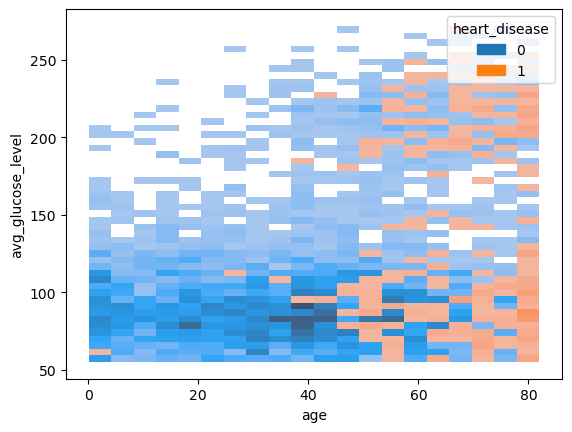

In [31]:
sns.histplot(df, x="age", y="avg_glucose_level", hue="heart_disease")

<Axes: xlabel='age', ylabel='avg_glucose_level'>

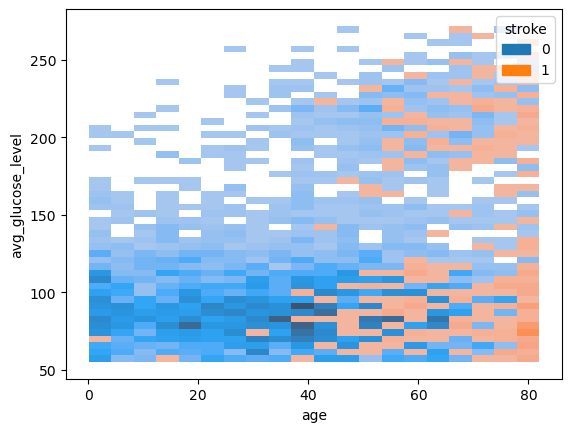

In [32]:
sns.histplot(df, x="age", y="avg_glucose_level", hue="stroke")

<font color='blue'>-> avg_glucose_level is bimodal and thus stroke is clustered amongst the two modes. Thus, heart_disease and stroke are not obviously dependent on glucose level<font>

<Axes: xlabel='age', ylabel='Count'>

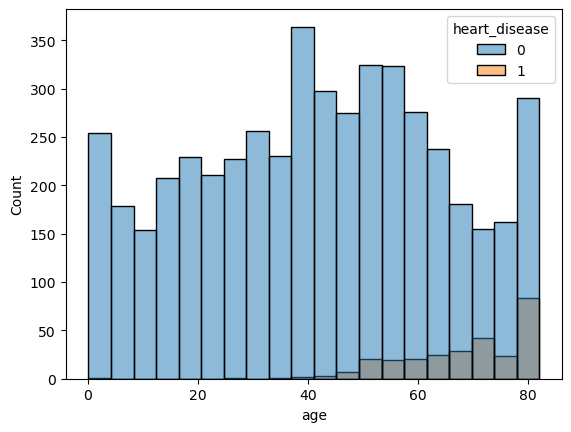

In [123]:
sns.histplot(df, x="age", hue="heart_disease")

<font color='red'>[TODO]: better legend for KDEplots with multiple variables for hue.</font>

<Axes: xlabel='age', ylabel='Density'>

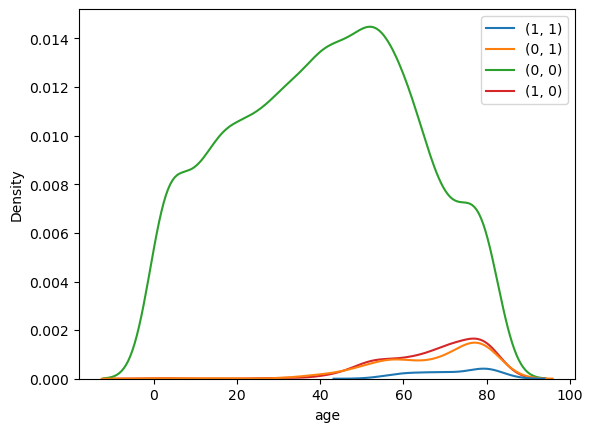

In [34]:
sns.kdeplot(df, x="age", hue=df[["heart_disease","stroke"]].apply(tuple, axis=1))

C:\Users\akrue\AppData\Local\Temp\ipykernel_14476\126682958.py:1: UserWarning: Dataset has 0 variance; skipping density estimate. Pass `warn_singular=False` to disable this warning.
  sns.kdeplot(df, x="age", hue=df[["heart_disease","gender"]].apply(tuple, axis=1))


<Axes: xlabel='age', ylabel='Density'>

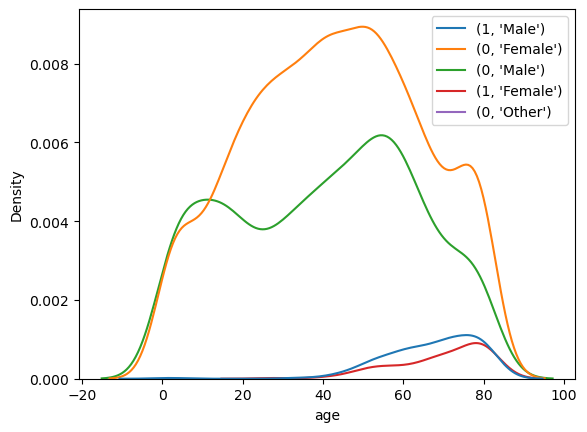

In [35]:
sns.kdeplot(df, x="age", hue=df[["heart_disease","gender"]].apply(tuple, axis=1))

<font color='blue'>-> age and gender appear to be a risk factor: The intervall 50 to 85 years is a risk factor (later other health risks may add up) and males appear to have a higher risk in this interval <font>

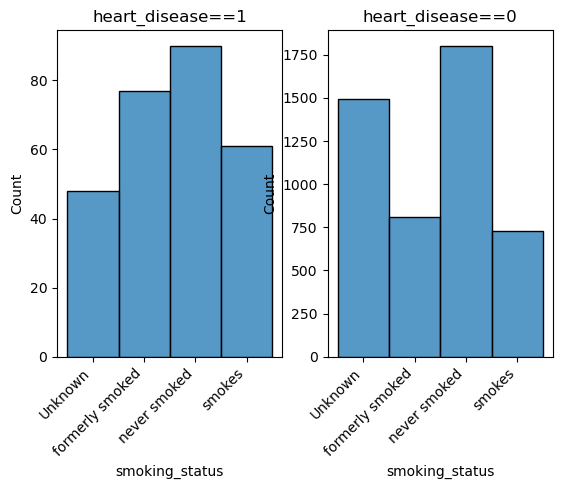

In [36]:
fig, axs = plt.subplots(1,2)
sns.histplot(df[df['heart_disease']==1], x="smoking_status",ax=axs[0])
axs[0].set_title('heart_disease==1')
sns.histplot(df[df['heart_disease']==0], x="smoking_status",ax=axs[1])
axs[1].set_title('heart_disease==0')
fig.autofmt_xdate(rotation=45)

<font color='blue'>-> distribution of smoking_status differs with heart_disease <font>

<Axes: xlabel='age', ylabel='bmi'>

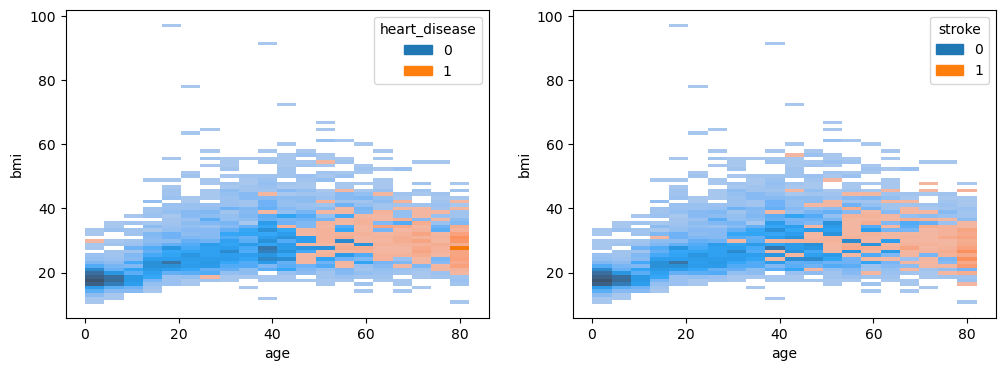

In [37]:
fig, axs = plt.subplots(1,2,figsize=(12,4))
sns.histplot(df, x="age", y="bmi", hue="heart_disease", ax=axs[0])
sns.histplot(df, x="age", y="bmi", hue="stroke", ax=axs[1])

In [38]:
df_stroke_and_heart = df[(df['stroke'] == 1) & (df['heart_disease'] == 1)]
df_neither_stroke_nor_heart = df[(df['stroke'] == 0) & (df['heart_disease'] == 0)]
df_either_stroke_or_heart =df[~df.isin(df_stroke_and_heart) & ~df.isin(df_neither_stroke_nor_heart)].dropna(how = 'all')

In [39]:
df_stroke_and_heart[['heart_disease','stroke']].groupby(['heart_disease', 'stroke']).size()

heart_disease  stroke
1              1         47
dtype: int64

In [40]:
df_neither_stroke_nor_heart[['heart_disease','stroke']].groupby(['heart_disease', 'stroke']).size()

heart_disease  stroke
0              0         4632
dtype: int64

In [41]:
df_either_stroke_or_heart[['heart_disease','stroke']].groupby(['heart_disease', 'stroke']).size()

heart_disease  stroke
0.0            1.0       202
1.0            0.0       229
dtype: int64

In [42]:
df.columns

Index(['id', 'gender', 'age', 'hypertension', 'heart_disease', 'ever_married',
       'work_type', 'Residence_type', 'avg_glucose_level', 'bmi',
       'smoking_status', 'stroke'],
      dtype='object')

C:\Users\akrue\AppData\Local\Temp\ipykernel_14476\441536054.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.drop(columns=['id','hypertension','heart_disease','stroke']).corr()


<Axes: >

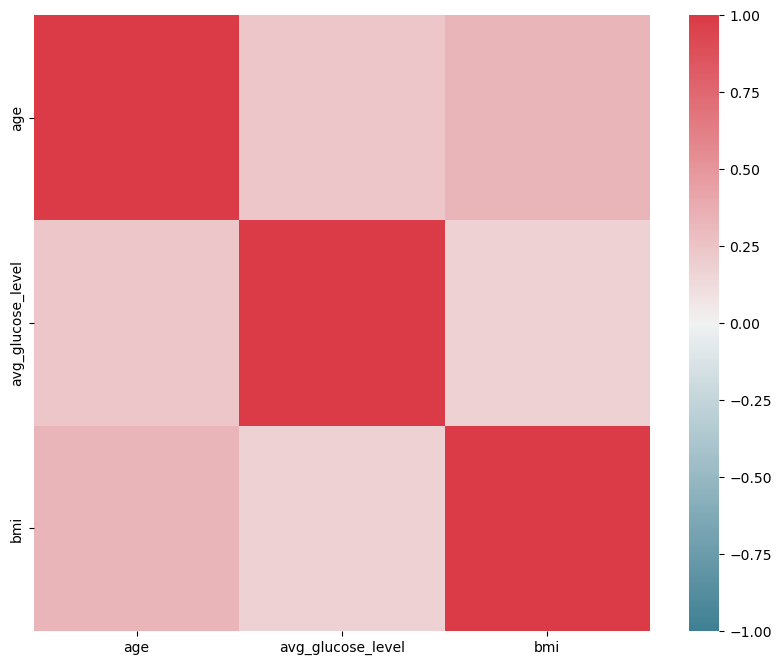

In [43]:
f, ax = plt.subplots(figsize=(10, 8))
corr = df.drop(columns=['id','hypertension','heart_disease','stroke']).corr()
sns.heatmap(corr,
    cmap=sns.diverging_palette(220, 10, as_cmap=True),
    vmin=-1.0, vmax=1.0,
    square=True, ax=ax)

<font color='blue'>-> There are no strong correlation in the three numerical variables.<font>

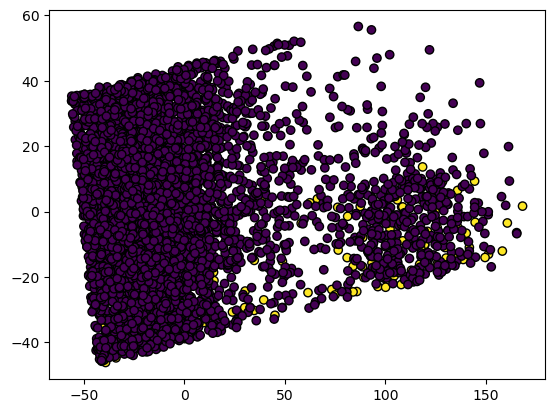

In [44]:
# Code source: Gaël Varoquaux
# License: BSD 3 clause


# unused but required import for doing 3d projections with matplotlib < 3.2


np.random.seed(5)
dfna = df.dropna()
X = dfna[['age', 'hypertension', 'heart_disease','avg_glucose_level','bmi']]
y = dfna['stroke']


plt.cla()
pca = decomposition.PCA(n_components=2)
pca.fit(X)
X = pca.transform(X)
# Reorder the labels to have colors matching the cluster results
y = np.choose(y, [1, 2, 0]).astype(float)
plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor="k")

ax.xaxis.set_ticklabels([])
ax.yaxis.set_ticklabels([])
plt.show()

## Preprocessing
Splitting dataset into relevant numericals and categorials to preprocess them.


In [45]:
X_numericals = df[['age', 'avg_glucose_level', 'bmi']]
X_categorials = df[['gender', 'hypertension', 'ever_married', 'work_type', 'Residence_type', 'smoking_status', 'stroke']]
y = df['heart_disease']

### Categorials
For an MVP, I use a one-hot-encoder for all categorial variables. Could be improved by using an ordinal encoder for ordinal variables.

In [46]:
one_hot_enc = preprocessing.OneHotEncoder()
one_hot_enc.fit(X_categorials)
X_categorials_enc = one_hot_enc.transform(X_categorials)

In [47]:
X_categorials_enc.shape

(5110, 20)

## Numericals

In [48]:
# Deal with missing values

In [49]:
X_numericals[X_numericals.isna().any(axis=1)].shape 

(201, 3)

In [50]:
imp_median = SimpleImputer(missing_values=np.nan, strategy='median')
imp_median.fit(X_numericals)
X_numericals_imp = imp_median.transform(X_numericals)

In [51]:
# Normalization because units differ
scaler = preprocessing.StandardScaler().fit(X_numericals_imp)
X_numericals_imp_scaled = scaler.transform(X_numericals_imp) 

In [52]:
test = pd.DataFrame(X_numericals_imp_scaled)

In [53]:
np.isnan(np.sum(X_numericals_imp_scaled))

False

array([[<Axes: title={'center': '0'}>, <Axes: title={'center': '1'}>],
       [<Axes: title={'center': '2'}>, <Axes: >]], dtype=object)

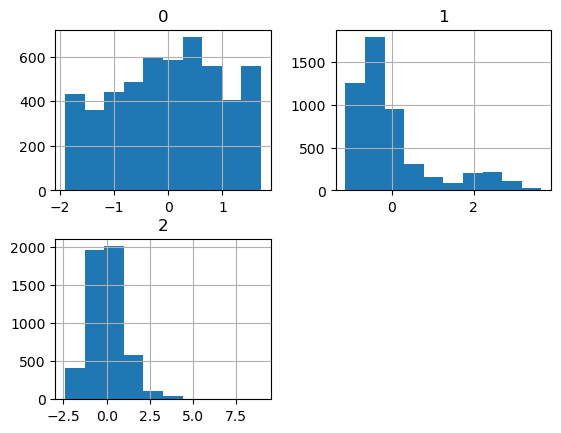

In [54]:
# normally distributed? 
test.hist()

### Combine numericals and categorial variables to a single X for ML

In [55]:
X_numericals_imp_scaled.shape

(5110, 3)

In [56]:
X_categorials_enc.shape

(5110, 20)

In [57]:
type(X_categorials_enc)

scipy.sparse._csr.csr_matrix

In [58]:
X_categorials_enc = X_categorials_enc.toarray()

In [59]:
type(X_categorials_enc)

numpy.ndarray

In [60]:
X = np.concatenate((X_categorials_enc, X_numericals_imp_scaled), axis=1)

In [61]:
X.shape

(5110, 23)

In [62]:
y.shape

(5110,)

Now I build a dataframe from X with the the features correctly named

In [63]:
dfX = pd.DataFrame(X,columns=['age', 'avg_glucose_level', 'bmi',]+list(one_hot_enc.get_feature_names_out()))

In [64]:
dfX.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 23 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   age                             5110 non-null   float64
 1   avg_glucose_level               5110 non-null   float64
 2   bmi                             5110 non-null   float64
 3   gender_Female                   5110 non-null   float64
 4   gender_Male                     5110 non-null   float64
 5   gender_Other                    5110 non-null   float64
 6   hypertension_0                  5110 non-null   float64
 7   hypertension_1                  5110 non-null   float64
 8   ever_married_No                 5110 non-null   float64
 9   ever_married_Yes                5110 non-null   float64
 10  work_type_Govt_job              5110 non-null   float64
 11  work_type_Never_worked          5110 non-null   float64
 12  work_type_Private               51

### Random undersampling, splitting training and test dataset

In [105]:
def make_random_undersampleling(X, y, sampling_strategy = 1, random_state=None):
    binary_mask = y.isin([0, 1])
    binary_y = y[binary_mask]
    binary_X = X[binary_mask]
    rus = RandomUnderSampler(sampling_strategy=sampling_strategy, random_state=random_state)
    X_res, y_res = rus.fit_resample(binary_X, binary_y)
    return X_res, y_res

In [116]:
def make_random_oversampleling(X, y, random_state=None):
    ros = RandomOverSampler(random_state=random_state)
    X_res, y_res = ros.fit_resample(X, y)
    return X_res, y_res

In [129]:
def make_SMOTE_oversampleling(X, y):
    X_res, y_res = SMOTE().fit_resample(X, y)
    return X_res, y_res 

In [108]:
X_res, y_res = make_random_undersampleling(X,y,sampling_strategy=1,random_state=42)

In [109]:
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.3, random_state=42)

## Training of an ML model and evaluation vs base model

<font color='red'>[TODO]: This ML part and the following model selection should be combined better: E.g. all metrics for all models, parameter tuning could be added etc. Because of my limited time, this must suffice for a preliminary result<font>

In [68]:
clf = SVC(kernel="linear", C=0.025, random_state=42)

In [69]:
clf.fit(X_train,y_train)

SVC(C=0.025, kernel='linear', random_state=42)

In [70]:
y_pred_svm = clf.predict(X_test)

<font color='red'>[TODO]: Add confusion matrix</font>

In [71]:
acc = accuracy_score(y_test,y_pred_svm)
prec = precision_score(y_test,y_pred_svm)
rec = recall_score(y_test,y_pred_svm)
f1 = f1_score(y_test,y_pred_svm)
print(f'accuracy: {acc:.2f}\nprecision: {prec:.2f}\nrecall {rec:.2f}\nf1: {f1:.2f}')

accuracy: 0.79
precision: 0.73
recall 0.92
f1: 0.81


In [72]:
y_pred_svm_all = clf.predict(X)
print(accuracy_score(y,y_pred_svm_all))
print(precision_score(y,y_pred_svm_all))
print(recall_score(y,y_pred_svm_all))
print(f1_score(y,y_pred_svm_all))

0.6561643835616439
0.12807634354595682
0.9239130434782609
0.2249669166299074


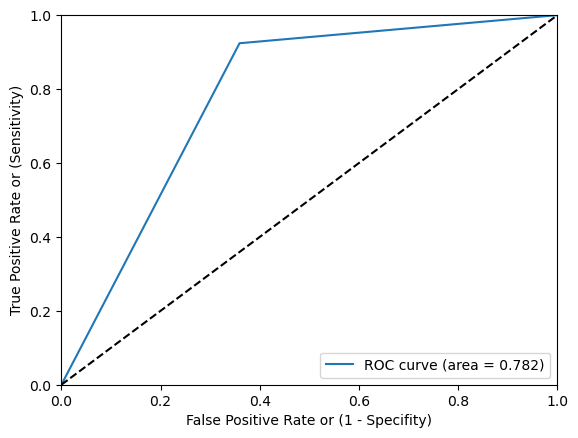

In [73]:
fpr, tpr, thresholds = roc_curve(y, y_pred_svm_all)
roc_auc = auc(fpr, tpr)

plt.plot(fpr, tpr, label='ROC curve (area = %0.3f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')  # random predictions curve
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.legend(loc="lower right")

In [74]:
scoring = {'acc': 'accuracy',
           'prec_macro': 'precision_macro',
           'rec_micro': 'recall_macro'}

In [75]:
score = cross_validate(clf, X_res, y_res, scoring=scoring, cv=5, return_train_score=True)

In [76]:
for item in score:
    mean = np.mean(score[item])
    print(f'{item} mean = {mean:.2f}')

fit_time mean = 0.01
score_time mean = 0.00
test_acc mean = 0.78
train_acc mean = 0.79
test_prec_macro mean = 0.80
train_prec_macro mean = 0.80
test_rec_micro mean = 0.78
train_rec_micro mean = 0.79


In [77]:
score = cross_validate(clf, X, y, scoring=scoring, cv=5, return_train_score=True)
for item in score:
    mean = np.mean(score[item])
    print(f'{item} mean = {mean:.2f}')

C:\Users\akrue\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\akrue\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\akrue\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\akrue\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedM

fit_time mean = 0.08
score_time mean = 0.02
test_acc mean = 0.95
train_acc mean = 0.95
test_prec_macro mean = 0.47
train_prec_macro mean = 0.47
test_rec_micro mean = 0.50
train_rec_micro mean = 0.50


C:\Users\akrue\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


<font color='blue'>-> the base line model without under or oversamoling is clearly worse. With a precision and recall of .8 the initial SVM offers a meaningful classifikation in comparision to the base model.<font>

### Model selection

<font color='red'> [TODO]: For a first evaluation, I took a set of classifiers from the sklearn docs. The choice of classifiers could be improved. Also, hyperparameters could be optimized. <font>  

In [78]:
names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

The quality of the classifier may depend on the chosen undersample, thus I draw 10 different undersamples and uns the mean as an estimator of the quality of this approach

In [79]:
# iterate over classifiers
scores = []
max_undersamples = 10
with open("logfile.txt", "a") as f:
    print(datetime.datetime.now(), file=f)
    for i in range(max_undersamples):
        print("undersample " + str(i) +" / " + str(max_undersamples))
        cur_undersample_scores = []
        X_res, y_res = make_random_undersampleling(X,y)
        for name, clf in zip(names, classifiers):
            cur_undersample_scores
            print(name+ 'scores ', file=f)
            score = cross_val_score(clf, X_res, y_res, scoring='f1', cv=10, n_jobs = -1)
            print(str(score) + " mean: " + str(np.mean(score)), file=f)
            cur_undersample_scores.append(np.mean(score))
        scores.append(cur_undersample_scores)    

undersample 0 / 10
undersample 1 / 10
undersample 2 / 10
undersample 3 / 10
undersample 4 / 10
undersample 5 / 10
undersample 6 / 10
undersample 7 / 10
undersample 8 / 10
undersample 9 / 10


In [80]:
pd.DataFrame(scores,columns=names).describe()

Nearest Neighbors  Linear SVM    RBF SVM  Gaussian Process  \
count          10.000000   10.000000  10.000000         10.000000   
mean            0.734931    0.802851   0.719899          0.783821   
std             0.025315    0.009539   0.018928          0.016055   
min             0.699723    0.787789   0.694764          0.764503   
25%             0.720025    0.796288   0.704297          0.769487   
50%             0.735251    0.802601   0.722704          0.781779   
75%             0.750300    0.807803   0.728958          0.798844   
max             0.773187    0.818572   0.756898          0.807126   

       Decision Tree  Random Forest  Neural Net   AdaBoost  Naive Bayes  \
count      10.000000      10.000000   10.000000  10.000000    10.000000   
mean        0.755308       0.766603    0.778685   0.766041     0.750906   
std         0.015606       0.013295    0.013984   0.014936     0.019670   
min         0.732993       0.740520    0.759759   0.738954     0.726416   
25%         0.749047       0.760963    0.765087   0.755201     0.742703   
50%         0.751955       0.767212    0.781866   0.768835     0.745184   
75%         0.764786       0.774517    0.791365   0.774669     0.753496   
max         0.781824       0.788325    0.792666   0.787484     0.789091   

             QDA  
count  10.000000  
mean    0.443277  
std     0.050816  
min     0.356638  
25%     0.408163  
50%     0.450745  
75%     0.467433  
max     0.524854

In [81]:
# iterate over classifiers
scores = []
max_undersamples = 10
with open("logfile.txt", "a") as f:
    print(datetime.datetime.now(), file=f)
    for i in range(max_undersamples):
        print("undersample " + str(i) +" / " + str(max_undersamples))
        cur_undersample_scores = []
        X_res, y_res = make_random_undersampleling(X,y)
        for name, clf in zip(names, classifiers):
            cur_undersample_scores
            print(name+ 'scores ', file=f)
            score = cross_val_score(clf, X_res, y_res, scoring='recall', cv=10, n_jobs = -1)
            print(str(score) + " mean: " + str(np.mean(score)), file=f)
            cur_undersample_scores.append(np.mean(score))
        scores.append(cur_undersample_scores)    

undersample 0 / 10
undersample 1 / 10
undersample 2 / 10
undersample 3 / 10
undersample 4 / 10
undersample 5 / 10
undersample 6 / 10
undersample 7 / 10
undersample 8 / 10
undersample 9 / 10


In [82]:
pd.DataFrame(scores,columns=names).describe()

Nearest Neighbors  Linear SVM    RBF SVM  Gaussian Process  \
count          10.000000   10.000000  10.000000         10.000000   
mean            0.756733    0.870952   0.860198          0.817566   
std             0.025393    0.013587   0.021128          0.013230   
min             0.727646    0.847751   0.828968          0.793915   
25%             0.735351    0.864087   0.842295          0.809854   
50%             0.758862    0.869577   0.867196          0.820833   
75%             0.770007    0.875926   0.872983          0.825397   
max             0.804365    0.894841   0.890608          0.833598   

       Decision Tree  Random Forest  Neural Net   AdaBoost  Naive Bayes  \
count      10.000000      10.000000   10.000000  10.000000    10.000000   
mean        0.803307       0.811442    0.809286   0.797606     0.927540   
std         0.031861       0.021671    0.018084   0.019884     0.056881   
min         0.750000       0.771958    0.772354   0.753836     0.862302   
25%         0.784689       0.798843    0.803274   0.787004     0.875827   
50%         0.806283       0.806415    0.813492   0.804299     0.927579   
75%         0.822354       0.830456    0.820800   0.811739     0.974868   
max         0.855159       0.837434    0.829894   0.818915     0.992857   

             QDA  
count  10.000000  
mean    0.416349  
std     0.087274  
min     0.297884  
25%     0.366071  
50%     0.382407  
75%     0.446958  
max     0.575132

### Model comparison with undersampling

In [124]:
random_state = 42
X_res, y_res = make_random_undersampleling(X,y,sampling_strategy=0.4,random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.3, random_state=42)
for name, clf in zip(names, classifiers):
    print(name)
    model = clf.fit(X_train, y_train)
    y_pred_tree = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred_tree)
    prec = precision_score(y_test,y_pred_tree)
    rec = recall_score(y_test,y_pred_tree)
    f1 = f1_score(y_test,y_pred_tree)
    print(f'\tfor test dataset:\n\taccuracy: {acc:.2f}\n\tprecision: {prec:.2f}\n\trecall {rec:.2f}\n\tf1: {f1:.2f}')
    #y_pred_tree_all = clf.predict(X)
    #acc_all = accuracy_score(y,y_pred_tree_all)
    #prec_all = precision_score(y,y_pred_tree_all)
    #rec_all = recall_score(y,y_pred_tree_all)
    #f1_all = f1_score(y,y_pred_tree_all)
    #print(f'\tfor whole dataset:\n\taccuracy: {acc_all:.2f}\n\tprecision: {prec_all:.2f}\n\trecall {rec_all:.2f}\n\tf1: {f1_all:.2f}')

Nearest Neighbors
	for test dataset:
	accuracy: 0.75
	precision: 0.55
	recall 0.49
	f1: 0.52
Linear SVM
	for test dataset:
	accuracy: 0.77
	precision: 0.60
	recall 0.43
	f1: 0.50
RBF SVM
	for test dataset:
	accuracy: 0.73
	precision: 0.47
	recall 0.08
	f1: 0.13
Gaussian Process
	for test dataset:
	accuracy: 0.78
	precision: 0.60
	recall 0.53
	f1: 0.57
Decision Tree
	for test dataset:
	accuracy: 0.72
	precision: 0.48
	recall 0.38
	f1: 0.43
Random Forest
	for test dataset:
	accuracy: 0.78
	precision: 0.66
	recall 0.36
	f1: 0.46
Neural Net
	for test dataset:
	accuracy: 0.79
	precision: 0.62
	recall 0.56
	f1: 0.59
AdaBoost
	for test dataset:
	accuracy: 0.73
	precision: 0.49
	recall 0.45
	f1: 0.47
Naive Bayes
	for test dataset:
	accuracy: 0.72
	precision: 0.49
	recall 0.80
	f1: 0.61
QDA
	for test dataset:
	accuracy: 0.73
	precision: 0.00
	recall 0.00
	f1: 0.00


C:\Users\akrue\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Model comparison with random oversampling

In [125]:
random_state = 42
X_res, y_res = make_random_oversampleling(X,y,random_state=random_state)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.3, random_state=42)
for name, clf in zip(names, classifiers):
    print(name)
    model = clf.fit(X_train, y_train)
    y_pred_tree = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred_tree)
    prec = precision_score(y_test,y_pred_tree)
    rec = recall_score(y_test,y_pred_tree)
    f1 = f1_score(y_test,y_pred_tree)
    print(f'\tfor test dataset:\n\taccuracy: {acc:.2f}\n\tprecision: {prec:.2f}\n\trecall {rec:.2f}\n\tf1: {f1:.2f}')
    #y_pred_tree_all = clf.predict(X)
    #acc_all = accuracy_score(y,y_pred_tree_all)
    #prec_all = precision_score(y,y_pred_tree_all)
    #rec_all = recall_score(y,y_pred_tree_all)
    #f1_all = f1_score(y,y_pred_tree_all)
    #print(f'\tfor whole dataset:\n\taccuracy: {acc_all:.2f}\n\tprecision: {prec_all:.2f}\n\trecall {rec_all:.2f}\n\tf1: {f1_all:.2f}')

Nearest Neighbors
	for test dataset:
	accuracy: 0.88
	precision: 0.82
	recall 0.98
	f1: 0.89
Linear SVM
	for test dataset:
	accuracy: 0.79
	precision: 0.76
	recall 0.87
	f1: 0.81
RBF SVM
	for test dataset:
	accuracy: 0.96
	precision: 0.93
	recall 0.98
	f1: 0.96
Gaussian Process
	for test dataset:
	accuracy: 0.92
	precision: 0.87
	recall 0.99
	f1: 0.93
Decision Tree
	for test dataset:
	accuracy: 0.82
	precision: 0.76
	recall 0.93
	f1: 0.84
Random Forest
	for test dataset:
	accuracy: 0.77
	precision: 0.71
	recall 0.89
	f1: 0.79
Neural Net
	for test dataset:
	accuracy: 0.82
	precision: 0.78
	recall 0.91
	f1: 0.84
AdaBoost
	for test dataset:
	accuracy: 0.81
	precision: 0.76
	recall 0.89
	f1: 0.82
Naive Bayes
	for test dataset:
	accuracy: 0.66
	precision: 0.60
	recall 0.99
	f1: 0.75
QDA
	for test dataset:
	accuracy: 0.53
	precision: 0.59
	recall 0.19
	f1: 0.29


C:\Users\akrue\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Model comparison with SMOTE oversampling

In [133]:
random_state = 42
X_res, y_res = make_SMOTE_oversampleling(X,y)
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.3, random_state=42)
for name, clf in zip(names, classifiers):
    print(name)
    model = clf.fit(X_train, y_train)
    y_pred_tree = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred_tree)
    prec = precision_score(y_test,y_pred_tree)
    rec = recall_score(y_test,y_pred_tree)
    f1 = f1_score(y_test,y_pred_tree)
    print(f'\tfor test dataset:\n\taccuracy: {acc:.2f}\n\tprecision: {prec:.2f}\n\trecall {rec:.2f}\n\tf1: {f1:.2f}')
    #y_pred_tree_all = clf.predict(X)
    #acc_all = accuracy_score(y,y_pred_tree_all)
    #prec_all = precision_score(y,y_pred_tree_all)
    #rec_all = recall_score(y,y_pred_tree_all)
    #f1_all = f1_score(y,y_pred_tree_all)
    #print(f'\tfor whole dataset:\n\taccuracy: {acc_all:.2f}\n\tprecision: {prec_all:.2f}\n\trecall {rec_all:.2f}\n\tf1: {f1_all:.2f}')

Nearest Neighbors
	for test dataset:
	accuracy: 0.88
	precision: 0.82
	recall 0.98
	f1: 0.89
Linear SVM
	for test dataset:
	accuracy: 0.81
	precision: 0.76
	recall 0.90
	f1: 0.82
RBF SVM
	for test dataset:
	accuracy: 0.94
	precision: 0.92
	recall 0.97
	f1: 0.94
Gaussian Process
	for test dataset:
	accuracy: 0.93
	precision: 0.88
	recall 0.98
	f1: 0.93
Decision Tree
	for test dataset:
	accuracy: 0.84
	precision: 0.79
	recall 0.92
	f1: 0.85
Random Forest
	for test dataset:
	accuracy: 0.81
	precision: 0.76
	recall 0.92
	f1: 0.83
Neural Net
	for test dataset:
	accuracy: 0.84
	precision: 0.79
	recall 0.93
	f1: 0.85
AdaBoost
	for test dataset:
	accuracy: 0.85
	precision: 0.82
	recall 0.91
	f1: 0.86
Naive Bayes
	for test dataset:
	accuracy: 0.67
	precision: 0.61
	recall 0.97
	f1: 0.75
QDA
	for test dataset:
	accuracy: 0.51
	precision: 0.51
	recall 0.18
	f1: 0.27


C:\Users\akrue\anaconda3\Lib\site-packages\sklearn\discriminant_analysis.py:935: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


### Explainable classifier

In [132]:
for treedepth in range(1,5):
    random_state = 42
    X_res, y_res = make_SMOTE_oversampleling(X,y)
    X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, train_size=0.3, random_state=42)
    clf = DecisionTreeClassifier(random_state=random_state,max_depth=treedepth)
    model = clf.fit(X_train, y_train)
    y_pred_tree = clf.predict(X_test)
    acc = accuracy_score(y_test,y_pred_tree)
    prec = precision_score(y_test,y_pred_tree)
    rec = recall_score(y_test,y_pred_tree)
    f1 = f1_score(y_test,y_pred_tree)
    print(f'for depth = {treedepth}:\n\taccuracy: {acc:.2f}\n\tprecision: {prec:.2f}\n\trecall {rec:.2f}\n\tf1: {f1:.2f}')
    text_representation = tree.export_text(clf)
    with open(f'visualization-tree-depth{treedepth}.txt','w') as f:
        print('Decision Tree Classifier visualization for undersample and classifier with random_state = '+ str(random_state),file=f)
        print(f'for depth = {treedepth}:\n\taccuracy: {acc:.2f}\n\tprecision: {prec:.2f}\n\trecall {rec:.2f}\n\tf1: {f1:.2f}',file=f)
        print(text_representation,file=f)

for depth = 1:
	accuracy: 0.79
	precision: 0.73
	recall 0.90
	f1: 0.81
for depth = 2:
	accuracy: 0.79
	precision: 0.72
	recall 0.95
	f1: 0.82
for depth = 3:
	accuracy: 0.81
	precision: 0.78
	recall 0.85
	f1: 0.81
for depth = 4:
	accuracy: 0.83
	precision: 0.77
	recall 0.92
	f1: 0.84


# Conclusion

The goal of predicting the binary variable heart disease from the given data set ist best adressed by the RFB SVM. The recall score .97 and good f1 score 0.94 describe good performance on the test data set. 

Importantly, the handling of the imbalance in the data set affects performance severely. Undersampling has proven suboptimal and random oversampling performs better but is still worse than SMOTE.

Also, hyperparameter tuning could improve the result. 

# Bayesian Analysis of Heart Failure

<font color='red'> [TODO]: Also, Bayesian analysis can predict heart failure. There is an example online that models the problem as logistic regression. <font>  

https://www.kaggle.com/code/monogenea/bayesian-approach-to-heart-failure-prediction